In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os as os

df_original = pd.read_csv('data_gdc/gdc_2006_2024_horapunto.csv', parse_dates=['fhora'])

df_original.info()
duplicados = df_original[df_original.duplicated(subset=['fhora'], keep=False)]

# Eliminar duplicados en 'fhora' antes de convertirla en índice
df_original = df_original.drop_duplicates(subset=['fhora'], keep='first')

# Luego convertir 'fhora' en índice
df_original.set_index('fhora', inplace=True)

df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158052 entries, 0 to 158051
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   fhora           158052 non-null  datetime64[ns, UTC]
 1   identificacion  158052 non-null  int64              
 2   ddd             158052 non-null  float64            
 3   dddstd          158052 non-null  int64              
 4   dddx            158052 non-null  int64              
 5   hr              158052 non-null  int64              
 6   lluv            114167 non-null  float64            
 7   pres            119874 non-null  float64            
 8   temp            106922 non-null  float64            
 9   ts              104754 non-null  float64            
 10  vel             125008 non-null  float64            
 11  velx            124626 non-null  float64            
 12  qdato           158052 non-null  int64              
dtypes: datetime64[

In [35]:
# Definir parámetros
ventana_horas = 6 * 30 * 24  
umbral_proporcion_nulos = 0.1  #10% de nulos
step_horas = 6 * 30 * 24  

# Función para identificar y eliminar años con exceso de nulos
def eliminar_periodos_con_exceso_nulos(df, ventana_horas, umbral_proporcion_nulos, step_horas):
    # Crear una copia del DataFrame para modificar
    df_cleaned = df.copy()

    # Crear una lista para almacenar los índices de los periodos a eliminar
    periodos_a_eliminar = []

    # Obtener el índice de tiempo del DataFrame
    index = df.index
    
    # Iniciar la ventana en el primer índice
    start_time = index[0]
    
    while start_time + pd.Timedelta(hours=ventana_horas) <= index[-1]:
        end_time = start_time + pd.Timedelta(hours=ventana_horas)
        
        # Extraer la ventana de datos
        ventana = df.loc[start_time:end_time]
        
        # Calcular la proporción de nulos en la ventana
        proporcion_nulos = ventana.isna().mean()
        
        # Verificar si la proporción de nulos supera el umbral
        if proporcion_nulos.max() > umbral_proporcion_nulos:
            periodos_a_eliminar.append((start_time, end_time))
        
        # Mover la ventana en el paso definido
        start_time += pd.Timedelta(hours=step_horas)
    
    # Eliminar los periodos identificados
    for start, end in periodos_a_eliminar:
        df_cleaned = df_cleaned.drop(df_cleaned.loc[start:end].index)
    
    return df_cleaned



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71863 entries, 2006-12-28 01:00:00+00:00 to 2024-03-23 23:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    70983 non-null  float64
dtypes: float64(1)
memory usage: 1.1 MB


In [41]:
# Inicializa un diccionario para almacenar los DataFrames
resultados = {}

for col in df_original.columns:
    # Extraer la columna actual
    df_columna = df_original[[col]]
    
    # Aplicar la función de eliminación de periodos con exceso de nulos
    df_limpio = eliminar_periodos_con_exceso_nulos(df_columna, ventana_horas, umbral_proporcion_nulos, step_horas)
    
    # Guardar el DataFrame resultante en el diccionario
    resultados[col] = df_limpio

# Para verificar los resultados, puedes imprimir las claves del diccionario
print(resultados.keys())

dict_keys(['identificacion', 'ddd', 'dddstd', 'dddx', 'hr', 'lluv', 'pres', 'temp', 'ts', 'vel', 'velx', 'qdato'])


In [46]:
resultados[target].info()
df_limpio = resultados[target]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71863 entries, 2006-12-28 01:00:00+00:00 to 2024-03-23 23:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    70983 non-null  float64
dtypes: float64(1)
memory usage: 1.1 MB


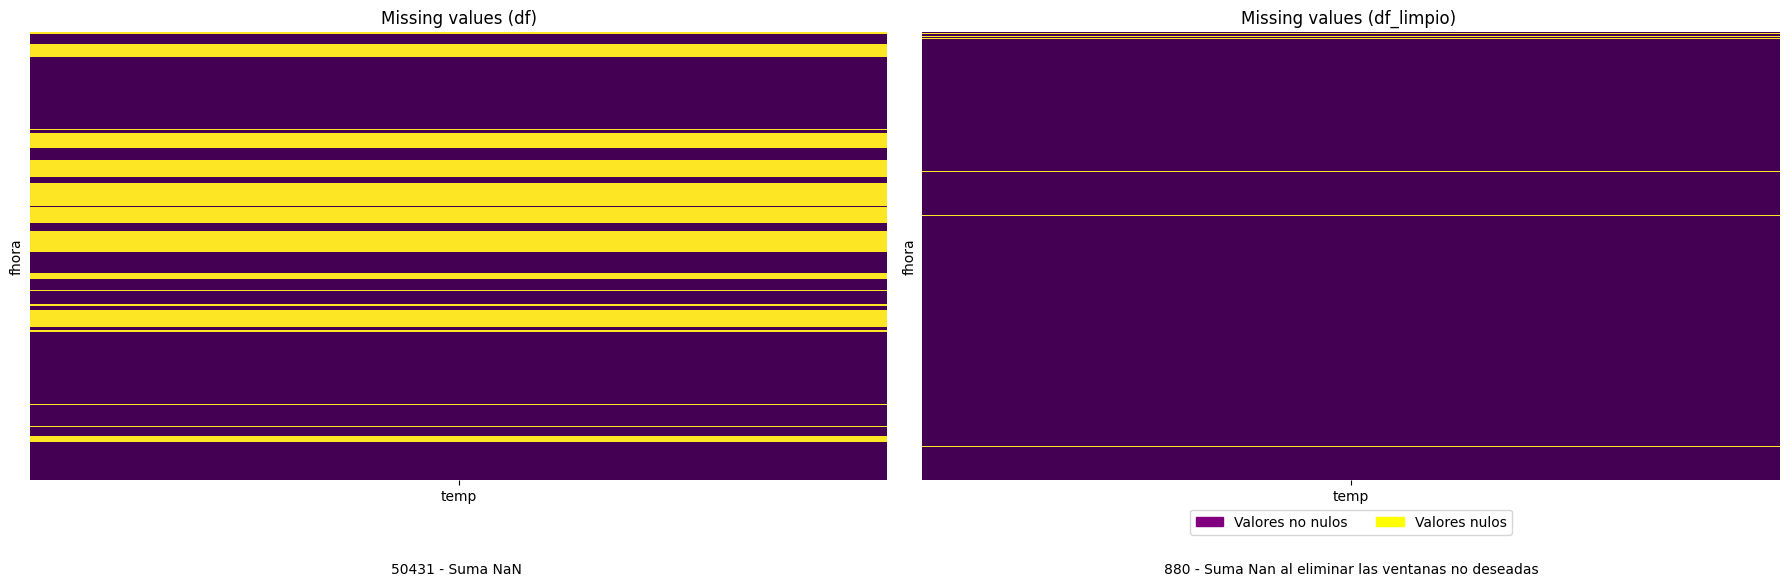

In [47]:
import matplotlib.patches as mpatches
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Primer gráfico: df original
sns.heatmap(df_original[[target]].isnull(), cbar=False, cmap='viridis', yticklabels=False, ax=axes[0])
axes[0].set_title(f'Missing values (df_original)')
axes[0].text(0.5, -0.2, f'{df_original[target].isnull().sum()} - Suma NaN ', 
             ha='center', va='center', transform=axes[0].transAxes)

# Segundo gráfico: df_sin_nulos
sns.heatmap(df_limpio[[target]].isnull(), cbar=False, cmap='viridis', yticklabels=False, ax=axes[1])
axes[1].set_title(f'Missing values (df_limpio) ')
axes[1].text(0.5, -0.2, f'{df_limpio[target].isnull().sum()} - Suma Nan al eliminar las ventanas no deseadas', 
             ha='center', va='center', transform=axes[1].transAxes)

#Tercer gráfico: Añade aquí el código para el tercer gráfico
# sns.heatmap(df_limpio[['temp']].isnull(), cbar=False, cmap='viridis', yticklabels=False, ax=axes[2])
# axes[2].set_title('Título del tercer gráfico')
# axes[2].text(0.5, -0.2, f'{df_limpio["temp"].isnull().sum()} - Suma NaN ', 
#              ha='center', va='center', transform=axes[2].transAxes)

# Añadir la leyenda
null_patch = mpatches.Patch(color='purple', label='Valores no nulos')  # Ajustar el color según el mapa de colores usado
non_null_patch = mpatches.Patch(color='yellow', label='Valores nulos')  # Ajustar el color según el mapa de colores usado
plt.legend(handles=[null_patch, non_null_patch], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

# Ajustar el espacio entre los gráficos para que no se solapen
plt.tight_layout()

# Mostrar la figura
plt.show()

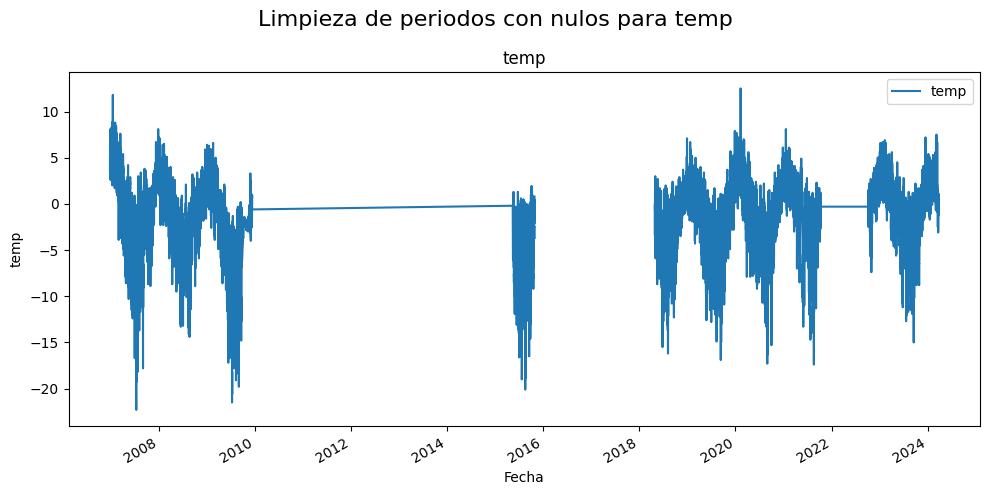

In [51]:
# Crear una figura con múltiples subgráficas
num_cols = len(df_limpio.columns)
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(10, 5 * num_cols))
fig.suptitle(f'Limpieza de periodos con nulos para {target}', fontsize=16)

if num_cols == 1:
    axes = [axes]  # Asegúrate de que 'axes' siempre sea una lista

# Iterar sobre las columnas y generar gráficos
for ax, col in zip(axes, df_limpio.columns):
    df_limpio[col].plot(ax=ax, title=col, legend=True)
    ax.set_ylabel(col)
    ax.set_xlabel('Fecha')

# Ajustar el diseño para que no se sobrepongan las etiquetas
plt.tight_layout()
plt.show()

*NOTA: El hueco y la línea recta representan periodos donde no hay datos.*

In [40]:
df_limpio.to_csv('test_gdc_limpio.csv')

## Periodo original para la columna target

In [ ]:
# Crear una figura con múltiples subgráficas
num_cols = len(df_original.columns)
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(10, 5 * num_cols))
fig.suptitle(f'Periodo original para la variable {target}', fontsize=16)

if num_cols == 1:
    axes = [axes]  # Asegúrate de que 'axes' siempre sea una lista

# Iterar sobre las columnas y generar gráficos
for ax, col in zip(axes, df_original.columns):
    df_original[col].plot(ax=ax, title=col, legend=True)
    ax.set_ylabel(col)
    ax.set_xlabel('Fecha')

# Ajustar el diseño para que no se sobrepongan las etiquetas
plt.tight_layout()
plt.show()